# Assignment
You are provided with a parallel corpus of English and French sentences. Your task is to build a neural translation model that uses an encoder-decoder architecture. The encoder will be based on LSTM to capture the sequential nature of the input language (English), and the decoder will be a combination of LSTM and CNN layers to generate the translated sentence in French.

Dataset:
Use the publicly available English-French parallel corpus or any suitable dataset of your choice.

Tasks:

Data Preprocessing:

Tokenize and clean the English and French sentences.Build a vocabulary for both languages.Convert sentences into sequences of integers using the vocabulary.

Model Building:

Build an LSTM-based encoder that processes the input English sentence.Create a CNN-based decoder to translate the encoded sentence into French.Use attention mechanisms to improve translation performance.Add batch normalization and regularization to improve the model’s generalization.

Training the Model:

Train the model on the provided dataset using an appropriate loss function (such as categorical cross-entropy) and optimizer (e.g., Adam).Monitor the model’s performance using metrics like BLEU score or perplexity.

Evaluation:

Test the trained model on unseen data.Evaluate the translation quality using BLEU scores.Compare the performance of your LSTM-CNN model with a pure LSTM-based model for translation.

Interpretability:

Visualize the attention mechanism to understand which words or parts of the sentence the model focuses on during translation.

### Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Conv1D, BatchNormalization, AdditiveAttention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
import re


### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/english-french.csv")
data['english'] = data['English words/sentences']
data['french'] = data['French words/sentences']
data = data.drop_duplicates(subset=['english'])
data.head(30)

,English words/sentences,French words/sentences,english,french
0,Hi.,Salut!,Hi.,Salut!
1,Run!,Cours !,Run!,Cours !
3,Who?,Qui ?,Who?,Qui ?
4,Wow!,Ça alors !,Wow!,Ça alors !
5,Fire!,Au feu !,Fire!,Au feu !
6,Help!,À l'aide !,Help!,À l'aide !
7,Jump.,Saute.,Jump.,Saute.
8,Stop!,Ça suffit !,Stop!,Ça suffit !
11,Wait!,Attends !,Wait!,Attends !
13,Go on.,Poursuis.,Go on.,Poursuis.


### Preprocess Text Data
This function converts text to lowercase, removes special characters, and trims spaces. Important for ensuring consistency before tokenization

In [ ]:
def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text
data['english'] = data['english'].apply(preprocess_text)
data['french'] = data['french'].apply(preprocess_text)
data = data.drop_duplicates(subset=['english'])
data.head(30)

,English words/sentences,French words/sentences,english,french
0,Hi.,Salut!,hi,salut
1,Run!,Cours !,run,cours
3,Who?,Qui ?,who,qui
4,Wow!,Ça alors !,wow,a alors
5,Fire!,Au feu !,fire,au feu
6,Help!,À l'aide !,help,laide
7,Jump.,Saute.,jump,saute
8,Stop!,Ça suffit !,stop,a suffit
11,Wait!,Attends !,wait,attends
13,Go on.,Poursuis.,go on,poursuis


### Initialize Tokenizers
This step tokenizes English and French sentences separately, creating word indexes for later embedding.

In [ ]:
eng_tokenizer = Tokenizer()
fr_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(data['english'])
fr_tokenizer.fit_on_texts(data['french'])

In [ ]:
# Example sentences for demonstration
example_sentences = data['english'].head(5)

# Tokenize the example sentences
sequences = eng_tokenizer.texts_to_sequences(example_sentences)

# Display the original sentences and their tokenized sequences
for i, sentence in enumerate(example_sentences):
  print(f"Original Sentence: {sentence}")
  print(f"Tokenized Sequence: {sequences[i]}")
  print("-" * 20)

# Get the word index mapping
word_index = eng_tokenizer.word_index
print("Word Index:")
# Print a limited number of entries to avoid cluttering the output
for word, index in list(word_index.items())[:10]:
    print(f"{word}: {index}")


Original Sentence: hi
Tokenized Sequence: [2919]
--------------------
Original Sentence: run
Tokenized Sequence: [447]
--------------------
Original Sentence: who
Tokenized Sequence: [83]
--------------------
Original Sentence: wow
Tokenized Sequence: [3827]
--------------------
Original Sentence: fire
Tokenized Sequence: [448]
--------------------
Word Index:
i: 1
to: 2
the: 3
you: 4
a: 5
is: 6
tom: 7
he: 8
that: 9
of: 10


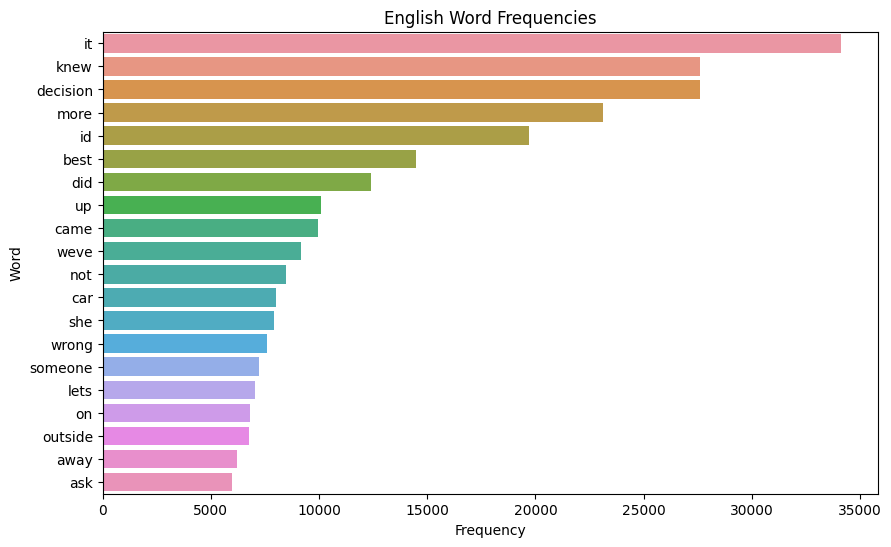

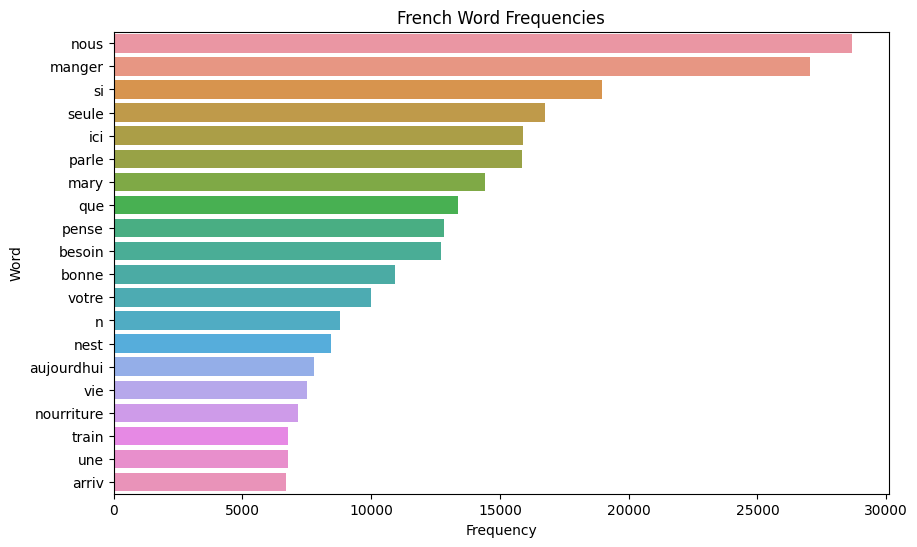

In [ ]:
# prompt: visualize tokenizer

import matplotlib.pyplot as plt
import seaborn as sns

# Get word counts for English and French
eng_word_counts = pd.DataFrame({'word': eng_tokenizer.word_index.keys(), 'count': eng_tokenizer.word_counts.values()})
fr_word_counts = pd.DataFrame({'word': fr_tokenizer.word_index.keys(), 'count': fr_tokenizer.word_counts.values()})


# Function to visualize word frequencies
def plot_word_frequencies(word_counts, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=word_counts.sort_values('count', ascending=False).head(20))  # Show top 20 words
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()


# Plot word frequencies
plot_word_frequencies(eng_word_counts, 'English Word Frequencies')
plot_word_frequencies(fr_word_counts, 'French Word Frequencies')


### Calculate Vocabulary Size

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

### Convert Text to Sequences
Converts text sentences into sequences of integers based on the tokenized vocabulary. Essential for model training

In [ ]:
eng_sequences = eng_tokenizer.texts_to_sequences(data['english'])
fr_sequences = fr_tokenizer.texts_to_sequences(data['french'])
max_len_eng = max(len(seq) for seq in eng_sequences)
max_len_fr = max(len(seq) for seq in fr_sequences)

In [ ]:
# prompt: generate code to see the effect of text to sequence on dataset

# Pad sequences to ensure uniform length
eng_padded_sequences = pad_sequences(eng_sequences, maxlen=max_len_eng, padding='post')
fr_padded_sequences = pad_sequences(fr_sequences, maxlen=max_len_fr, padding='post')

# Print the shapes of the padded sequences
print("Shape of English padded sequences:", eng_padded_sequences.shape)
print("Shape of French padded sequences:", fr_padded_sequences.shape)

# Example: Display the first 5 padded sequences
for i in range(5):
    print(f"Original English sentence: {data['english'].iloc[i]}")  # Changed line
    print(f"Padded English sequence: {eng_padded_sequences[i]}")
    print(f"Original French sentence: {data['french'].iloc[i]}")  # Changed line
    print(f"Padded French sequence: {fr_padded_sequences[i]}")
    print("-" * 20)


Shape of English padded sequences: (122954, 44)
Shape of French padded sequences: (122954, 54)
Original English sentence: hi
Padded English sequence: [2919    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Original French sentence: salut
Padded French sequence: [3934    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
--------------------
Original English sentence: run
Padded English sequence: [447   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
Original French sentence: cours 
Padd

### Pad Sequences

In [ ]:
eng_padded = pad_sequences(eng_sequences, maxlen=max_len_eng, padding='post')
fr_padded = pad_sequences(fr_sequences, maxlen=max_len_fr, padding='post')

### Split Dataset into Training and Testing Sets

In [ ]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(eng_padded, fr_padded, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 124,   59,  399, ...,    0,    0,    0],
       [  13,  573,    2, ...,    0,    0,    0],
       [   4,   36,  867, ...,    0,    0,    0],
       ...,
       [  25,    6,  164, ...,    0,    0,    0],
       [  25,  560,    2, ...,    0,    0,    0],
       [1350,    2,  101, ...,    0,    0,    0]], dtype=int32)

In [ ]:
X_test

array([[   1,   60,   33, ...,    0,    0,    0],
       [   1,  382,  132, ...,    0,    0,    0],
       [  83,   45,    4, ...,    0,    0,    0],
       ...,
       [  22,  288,  294, ...,    0,    0,    0],
       [  22,   27,   28, ...,    0,    0,    0],
       [  21, 1130,    2, ...,    0,    0,    0]], dtype=int32)

### Checking for any data leakage

In [ ]:
# 1. Check for duplicate sequences between train and test
train_set = set(map(tuple, X_train))
test_set = set(map(tuple, X_test))
duplicates = train_set.intersection(test_set)

if duplicates:
    print(f"Warning: {len(duplicates)} duplicate sequences found between train and test sets!")

# 2. Check for target leakage (same input-output pairs in train and test)
train_pairs = set(zip(map(tuple, X_train), map(tuple, y_train)))
test_pairs = set(zip(map(tuple, X_test), map(tuple, y_test)))
leaked_pairs = train_pairs.intersection(test_pairs)

if leaked_pairs:
    print(f"Warning: {len(leaked_pairs)} input-output pairs are shared between train and test sets!")

print("Data leakage checks complete.")

Data leakage checks complete.


## Model Architecture (Pure LSTM)

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
embedding_dim = 256
lstm_units = 256

# Encoder
encoder_inputs = Input(shape=(max_len_eng,))
embedding_enc = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
lstm_encoder = LSTM(lstm_units, return_sequences=True, return_state=True, kernel_regularizer=l2(0.001))
encoder_outputs, state_h, state_c = lstm_encoder(embedding_enc)
encoder_outputs = Dropout(0.5)(encoder_outputs)  # Dropout for regularization


In [ ]:
decoder_inputs = Input(shape=(max_len_fr - 1,))
embedding_dec = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
lstm_decoder = LSTM(lstm_units, return_sequences=True, return_state=True, kernel_regularizer=l2(0.001))
decoder_outputs, _, _ = lstm_decoder(embedding_dec, initial_state=[state_h, state_c])
decoder_outputs = Dropout(0.5)(decoder_outputs)


In [ ]:
attention_layer = AdditiveAttention()([decoder_outputs, encoder_outputs])
concatenated = Concatenate(axis=-1)([decoder_outputs, attention_layer])
# Final Dense Layer
output_layer = Dense(fr_vocab_size, activation='softmax')(concatenated)


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow.keras.backend as K
model = Model([encoder_inputs, decoder_inputs], output_layer)
loss_function = SparseCategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size')

def masked_accuracy(y_true, y_pred):
    y_true = K.cast(y_true, dtype='int32')
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')  # Mask padding tokens (0)
    correct = K.cast(K.equal(K.cast(K.argmax(y_pred, axis=-1), dtype='int32'), y_true), dtype='float32')
    return K.sum(correct * mask) / K.sum(mask)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=[masked_accuracy])

# Train Model
history=model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 366s 293ms/step - loss: 1.2781 - masked_accuracy: 0.0266 - val_loss: 0.6598 - val_masked_accuracy: 0.1017
Epoch 2/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 372s 303ms/step - loss: 0.6814 - masked_accuracy: 0.1035 - val_loss: 0.6065 - val_masked_accuracy: 0.1433
Epoch 3/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 372s 302ms/step - loss: 0.5855 - masked_accuracy: 0.1463 - val_loss: 0.5498 - val_masked_accuracy: 0.1925
Epoch 4/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 372s 302ms/step - loss: 0.5224 - masked_accuracy: 0.1920 - val_loss: 0.5092 - val_masked_accuracy: 0.2294
Epoch 5/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 373s 303ms/step - loss: 0.4705 - masked_accuracy: 0.2362 - val_loss: 0.4778 - val_masked_accuracy: 0.2677
Epoch 6/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 373s 303ms/step - loss: 0.4208 - masked_accuracy: 0.2802 - val_loss: 0.4510 - val_masked_accuracy: 0.3069
Epoch 7/25
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 373s 303ms/step - loss: 0.3786 - masked_accuracy: 0.3188 - val_loss: 0

In [ ]:
sample_size = 10
preds = model.predict([X_test[:sample_size], y_test[:sample_size, :-1]])
y_pred = np.argmax(preds, axis=-1)

def sequence_to_text(sequence, tokenizer):
    reverse_word_map = {index: word for word, index in tokenizer.word_index.items()}
    return " ".join([reverse_word_map.get(i, "?") for i in sequence if i > 0])

for i in range(sample_size):
    actual = sequence_to_text(y_test[i, 1:], fr_tokenizer)
    predicted = sequence_to_text(y_pred[i], fr_tokenizer)
    print(f"Actual: {actual}")
    print(f"Predicted: {predicted}\n")

# BLEU Score
bleu_score1 = corpus_bleu([[ref] for ref in y_test[:sample_size, 1:]], y_pred)
print("BLEU Score (10 samples):", bleu_score1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Actual: ne savais pas que tu savais cuisiner aussi bien
Predicted: ne savais pas que vous pourrais lire bien

Actual: le franais lcole
Predicted: lcole franais lcole

Actual: astu donn le livre 
Predicted: astu donn le livre

Actual: emploi du temps donne les heures darrive et de dpart
Predicted: livre le travail se la courses pour le le la

Actual: ny a aucun moyen de confirmer quil est en vie
Predicted: ny a pas moyen de trouver cette est pauvre train

Actual: manque vraiment de profondeur
Predicted: une une une quoi ce

Actual: garon timide murmura son nom
Predicted: nom a son son nom

Actual: donnerontils un concert
Predicted: nous nous concert nous

Actual: avait beaucoup de choses faire
Predicted: avait beaucoup de choses faire

Actual: tait tendu sur le dos
Predicted: est allong dans le dos

BLEU Score (10 samples): 0.9181594709624865


### Graph for loss

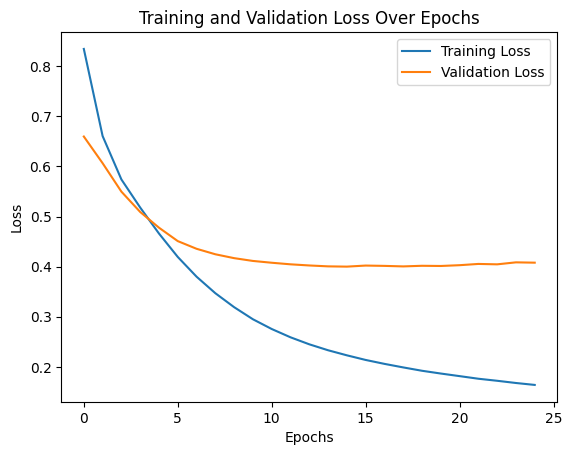

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.show()


### Graph for accuracy

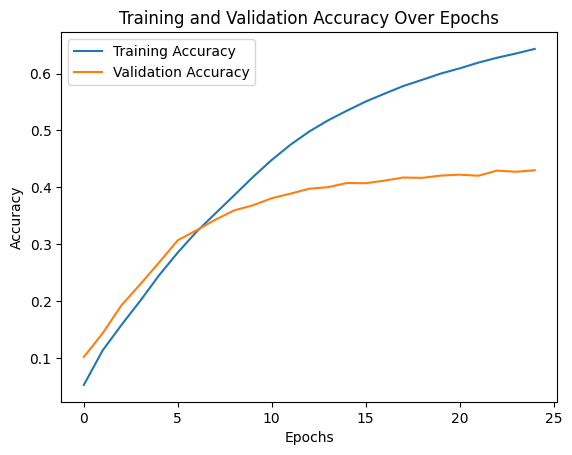

In [ ]:
plt.plot(history.history['masked_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_masked_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.show()


### Define Model Architecture (Encoder-Decoder with Attention)

Sets embedding and LSTM hidden state dimensions
Defines the encoder with an embedding layer and an LSTM. The encoder outputs only states (state_h, state_c) since it's a sequence-to-sequence model

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

embedding_dim = 256
encoder_inputs = Input(shape=(max_len_eng,))
embedding = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
lstm_encoder = LSTM(256, return_sequences=True, return_state=True,kernel_regularizer=l2(0.001))
encoder_outputs, state_h, state_c = lstm_encoder(embedding)
encoder_outputs = Dropout(0.5)(encoder_outputs)  # Add Dropout


The decoder processes French sequences. It takes the final states of the encoder as its initial state. Explain why return_sequences=Tru

In [ ]:
decoder_inputs = Input(shape=(max_len_fr - 1,))  # Adjusted to match shifted target length
embedding_dec = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
cnn_layer = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(embedding_dec)
cnn_layer = BatchNormalization()(cnn_layer)

lstm_decoder = LSTM(256, return_sequences=True, return_state=True,kernel_regularizer=l2(0.0001))
decoder_outputs, _, _ = lstm_decoder(cnn_layer, initial_state=[state_h, state_c])
decoder_outputs = Dropout(0.5)(decoder_outputs)  # Add Dropout


Implements an attention mechanism to enhance context understanding by weighting encoder outputs dynamically.

In [ ]:
attention_layer = AdditiveAttention()([decoder_outputs, encoder_outputs])
concatenated = Concatenate(axis=-1)([decoder_outputs, attention_layer])

output_layer = Dense(fr_vocab_size, activation='softmax')(concatenated)

### Compile and Train the Model

In [ ]:
model = Model([encoder_inputs, decoder_inputs], output_layer)
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss_function = SparseCategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size')
import tensorflow.keras.backend as K

def masked_accuracy(y_true, y_pred):
    y_true = K.cast(y_true, dtype='int32')
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')  # Mask padding tokens (0)
    correct = K.cast(K.equal(K.cast(K.argmax(y_pred, axis=-1), dtype='int32'), y_true), dtype='float32')

    return K.sum(correct * mask) / K.sum(mask)

model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=[masked_accuracy])

#model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=['accuracy'])

In [ ]:
X_train

array([[ 124,   59,  399, ...,    0,    0,    0],
       [  13,  573,    2, ...,    0,    0,    0],
       [   4,   36,  867, ...,    0,    0,    0],
       ...,
       [  25,    6,  164, ...,    0,    0,    0],
       [  25,  560,    2, ...,    0,    0,    0],
       [1350,    2,  101, ...,    0,    0,    0]], dtype=int32)

In [ ]:
history=model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 383s 308ms/step - loss: 1.0931 - masked_accuracy: 0.1797 - val_loss: 0.1990 - val_masked_accuracy: 0.8075
Epoch 2/5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 379s 308ms/step - loss: 0.1658 - masked_accuracy: 0.8267 - val_loss: 0.0985 - val_masked_accuracy: 0.9052
Epoch 3/5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 379s 309ms/step - loss: 0.0888 - masked_accuracy: 0.9062 - val_loss: 0.0680 - val_masked_accuracy: 0.9345
Epoch 4/5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 379s 308ms/step - loss: 0.0594 - masked_accuracy: 0.9369 - val_loss: 0.0554 - val_masked_accuracy: 0.9486
Epoch 5/5
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 380s 309ms/step - loss: 0.0428 - masked_accuracy: 0.9535 - val_loss: 0.0488 - val_masked_accuracy: 0.9563


### Graph for loss

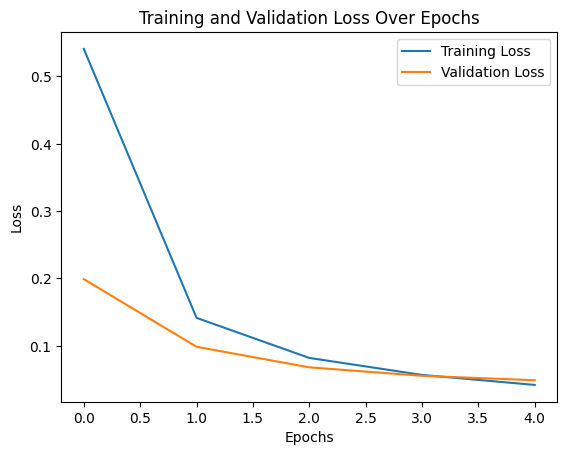

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.show()


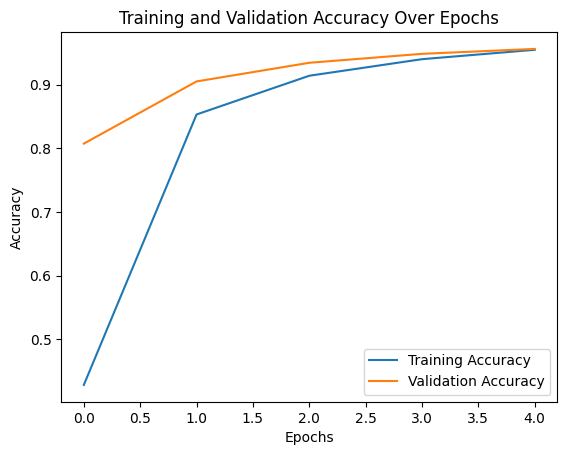

In [ ]:

plt.plot(history.history['masked_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_masked_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.show()


### BLEU Score

In [ ]:
sample_size = 100
preds = model.predict([X_test[:sample_size], y_test[:sample_size, :-1]])
y_pred = np.argmax(preds, axis=-1)

def sequence_to_text(sequence, tokenizer):
    reverse_word_map = {index: word for word, index in tokenizer.word_index.items()}
    return " ".join([reverse_word_map.get(i, "?") for i in sequence if i > 0])

for i in range(sample_size):
    actual = sequence_to_text(y_test[i, 1:], fr_tokenizer)
    predicted = sequence_to_text(y_pred[i], fr_tokenizer)
    print(f"Actual: {actual}")
    print(f"Predicted: {predicted}\n")

# BLEU Score
bleu_score = corpus_bleu([[ref] for ref in y_test[:sample_size, 1:]], y_pred)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Actual: ne savais pas que tu savais cuisiner aussi bien
Predicted: ne savais pas que tu savais cuisiner aussi bien

Actual: le franais lcole
Predicted: le franais lcole

Actual: astu donn le livre 
Predicted: astu donn le livre 

Actual: emploi du temps donne les heures darrive et de dpart
Predicted: emploi du temps donne les heures lectriques et de dpart

Actual: ny a aucun moyen de confirmer quil est en vie
Predicted: ny a aucun moyen de confirmer quil est en vie

Actual: manque vraiment de profondeur
Predicted: manque vraiment de profondeur

Actual: garon timide murmura son nom
Predicted: garon timide son nom

Actual: donnerontils un concert
Predicted: intressezvous un concert

Actual: avait beaucoup de choses faire
Predicted: avait beaucoup de choses faire

Actual: tait tendu sur le dos
Predicted: tait tendu sur le dos

Actual: me suis lev trs tt ce matin
Predicted: me suis lev trs tt ce matin

Actual: tous ces gteaux cest celuil que je prfre
P

Example

In [ ]:
import numpy as np

sample_idx = 9

predicted_probs = preds[sample_idx]

predicted_token_ids = np.argmax(predicted_probs, axis=-1)

predicted_words = sequence_to_text(predicted_token_ids, fr_tokenizer)

print("Predicted probabilities:\n", predicted_probs)
print("\nPredicted token IDs:\n", predicted_token_ids)
print("\nPredicted words:\n", predicted_words)

Predicted probabilities:
 [[7.3995096e-07 2.9043718e-12 2.5193028e-16 ... 7.0345791e-12
  6.9236162e-12 8.4209263e-12]
 [5.0408242e-05 2.8371140e-14 2.4926668e-17 ... 4.5460349e-10
  4.2630113e-10 5.5579374e-10]
 [2.5388826e-07 9.1951224e-11 1.7123040e-10 ... 2.0985139e-11
  2.1023438e-11 2.2389497e-11]
 ...
 [1.0000000e+00 6.1103097e-17 7.8388605e-15 ... 3.5104561e-13
  3.1425540e-13 4.8221523e-13]
 [1.0000000e+00 6.1144834e-17 7.8393391e-15 ... 3.5094250e-13
  3.1417387e-13 4.8206621e-13]
 [1.0000000e+00 1.9061978e-16 3.7629439e-14 ... 8.1930784e-13
  7.4630704e-13 1.1144530e-12]]

Predicted token IDs:
 [  49 2035   46    6  996    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]

Predicted words:
 tait tendu sur le dos


In [ ]:
# Assuming `selected_bleu_score` is from CNN-LSTM and `bleu_score1` is from pure LSTM
print(f"BLEU Score (CNN-LSTM): {bleu_score:.4f}")
print(f"BLEU Score (LSTM): {bleu_score1:.4f}")

# Compare the two models
if bleu_score > bleu_score1:
    print("CNN-LSTM performs better based on BLEU score.")
elif bleu_score < bleu_score1:
    print("Pure LSTM performs better based on BLEU score.")
else:
    print("Both models have the same BLEU score.")


BLEU Score (CNN-LSTM): 0.9507
BLEU Score (LSTM): 0.9182
CNN-LSTM performs better based on BLEU score.
